In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
image_size = [256,256]
data_path = '/content/drive/My Drive/ECE247/Brain_Tumor_Project/Harvard Medical Dataset2' #use correct data path

In [ ]:
conv = VGG16(input_shape= image_size+[3],weights='imagenet',include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv.output

<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
for layer in conv.layers:
    layer.trainable = False

In [ ]:
x = conv.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dense(1024,activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(.2)(x)
pred = Dense(2,activation='softmax')(x)
model = Model(inputs = conv.input,outputs=pred)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [ ]:
train_datagen=ImageDataGenerator(
    rescale=1/255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=True,
    validation_split=0.2)

train_generator=train_datagen.flow_from_directory(data_path, target_size=(256,256), color_mode='rgb', shuffle=False, subset='training', batch_size=10, class_mode='categorical')
val_generator = train_datagen.flow_from_directory(data_path, target_size=(256,256), color_mode='rgb', shuffle=False, subset='validation', batch_size=10, class_mode='categorical')

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])


Found 122 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [ ]:
print(train_generator.n)
print(train_generator.batch_size)
print(242//32)

122
10
7


In [ ]:
print(val_generator.n)
print(val_generator.batch_size)

30
10


In [ ]:
step_size_train=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator, steps_per_epoch=step_size_train, epochs=40,  verbose=1, validation_data=val_generator)

Epoch 1/40
12/12 [==============================] - 166s 13s/step - loss: 1.4942 - accuracy: 0.3393 - val_loss: 0.7548 - val_accuracy: 0.5333
Epoch 2/40
12/12 [==============================] - 139s 12s/step - loss: 0.7431 - accuracy: 0.5804 - val_loss: 0.6930 - val_accuracy: 0.5333
Epoch 3/40
12/12 [==============================] - 130s 11s/step - loss: 0.7147 - accuracy: 0.3750 - val_loss: 0.6857 - val_accuracy: 0.7667
Epoch 4/40
12/12 [==============================] - 114s 10s/step - loss: 0.7076 - accuracy: 0.5446 - val_loss: 0.6806 - val_accuracy: 0.5333
Epoch 5/40
12/12 [==============================] - 132s 11s/step - loss: 0.6830 - accuracy: 0.6071 - val_loss: 0.6675 - val_accuracy: 0.5333
Epoch 6/40
12/12 [==============================] - 132s 12s/step - loss: 0.6904 - accuracy: 0.5000 - val_loss: 0.6502 - val_accuracy: 0.5333
Epoch 7/40
12/12 [==============================] - 131s 11s/step - loss: 0.6793 - accuracy: 0.5625 - val_loss: 0.6920 - val_accuracy: 0.4667
Epoch 

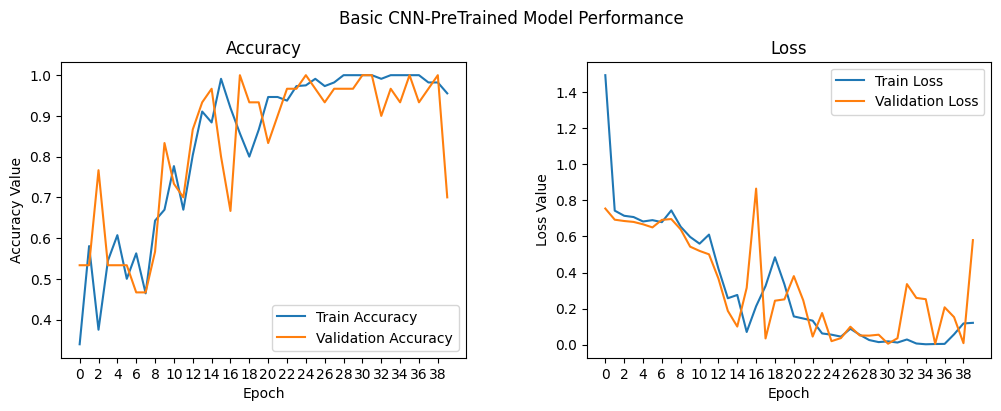

In [ ]:
import matplotlib.pyplot as plt
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN-PreTrained Model Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(0,40))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 40, 2))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 40, 2))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(val_generator, val_generator.n // val_generator.batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)


In [ ]:
print(val_generator.classes)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))

Confusion Matrix
[[16  0]
 [ 8  6]]


In [ ]:
print('Classification Report')
target_names = ['Abnormal', 'Normal']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Abnormal       0.67      1.00      0.80        16
      Normal       1.00      0.43      0.60        14

    accuracy                           0.73        30
   macro avg       0.83      0.71      0.70        30
weighted avg       0.82      0.73      0.71        30



Text(113.9222222222222, 0.5, 'True Values')

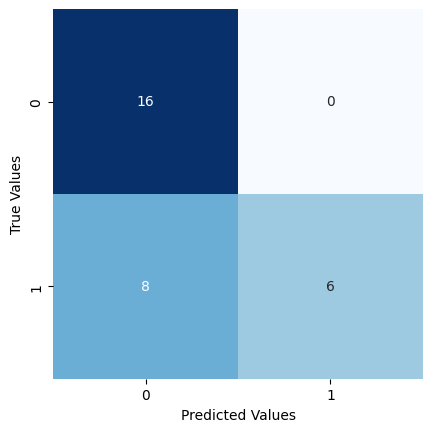

In [ ]:
import seaborn as sns
cm=confusion_matrix(val_generator.classes, y_pred)
sns.heatmap(cm, square=True, annot=True, cbar=False, cmap=plt.cm.Blues)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')

[Text(0, 0.5, 'Abnormal'), Text(0, 1.5, 'Normal')]

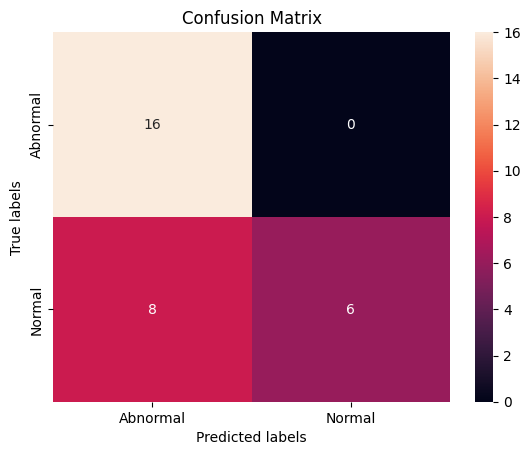

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Abnormal', 'Normal']); ax.yaxis.set_ticklabels(['Abnormal', 'Normal'])

Confusion Matrix :
[[16  0]
 [ 8  6]]
Accuracy Score : 0.7333333333333333
Report : 
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        16
           1       1.00      0.43      0.60        14

    accuracy                           0.73        30
   macro avg       0.83      0.71      0.70        30
weighted avg       0.82      0.73      0.71        30



<Axes: >

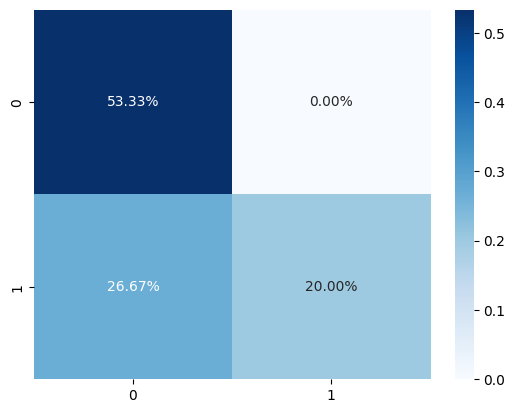

In [ ]:
from sklearn.metrics import accuracy_score
results = confusion_matrix(val_generator.classes,y_pred)
print('Confusion Matrix :')
print(results)
print('Accuracy Score :',accuracy_score(val_generator.classes,y_pred))
print('Report : ')
print(classification_report(val_generator.classes,y_pred))

sns.heatmap(results/np.sum(results), annot=True,
            fmt='.2%', cmap='Blues')

In [ ]:
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(val_generator.classes, y_pred, pos_label=1)
metrics.auc(fpr, tpr)

0.7142857142857143

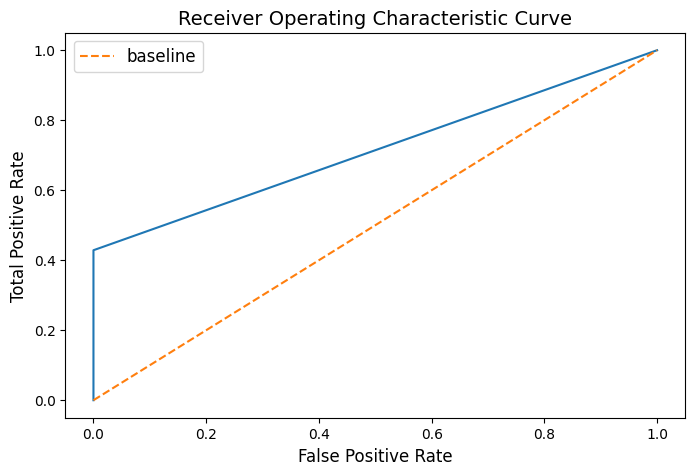

In [ ]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(fpr, tpr)
ax.plot(np.linspace(0, 1, 100),
         np.linspace(0, 1, 100),
         label='baseline',
         linestyle='--')
plt.title('Receiver Operating Characteristic Curve', fontsize=14)
plt.ylabel('Total Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.legend(fontsize=12);

In [ ]:
model.save('/content/drive/MyDrive/ECE247/Brain_Tumor_Project/model_params/my_VGG16finalmodel.h5')

In [ ]:
model.save_weights('/content/drive/MyDrive/ECE247/Brain_Tumor_Project/model_params/my_VGG16finalweight')